In [1]:
import sys
sys.path.insert(0, '../src/')

from netgan.netgan import *
import tensorflow as tf
import torch
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time
from net.utils import *
import net.net as net
import pandas as pd
%matplotlib inline

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/holgerizor/anaconda3/envs/ne

#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [5]:
rw_len = 16
batch_size = 128
mixing_coeff = 1

In [6]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### Create our Net model

In [26]:
netmodel = net.Net(N=_N,
                   H=24,
                   loss_fn=torch.nn.functional.cross_entropy,
                   loggers=[net.GraphStatisticsLogger(train_graph, mixing_coeff=mixing_coeff, log_every=100),
                            net.BasicPrintLogger(print_every=100)])

#### Train our model

In [27]:
netmodel.train(generator=net_walker(walker),
               steps=1000,
               optimizer_fn=torch.optim.Adam,
               optimizer_args={'lr': 0.01})

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Step: 99, Loss: 4.74758
Step: 199, Loss: 2.68367
Step: 299, Loss: 2.27469
Step: 399, Loss: 2.19863
Step: 499, Loss: 2.17749
Step: 599, Loss: 2.10574
Step: 699, Loss: 2.08487
Step: 799, Loss: 2.12677
Step: 899, Loss: 2.07596
Step: 999, Loss: 2.04842


In [19]:
def get_plot_grid_size(k):
    rows = int(np.ceil(np.sqrt(k)))
    if k <= rows * (rows - 1):
        cols = rows - 1
    else:
        cols = rows
    return rows, cols

In [20]:
def print_statistics(dict_of_lists_of_statistic, keys, reference_dict_of_statistics=None):
    if reference_dict_of_statistics:
        reference_dict_of_statistics['overlap'] = 1.
    n_rows, n_cols = get_plot_grid_size(len(keys))
    f, axs = plt.subplots(n_rows, n_cols, sharex=True, figsize=(12, 12))
    plt.tight_layout(pad=2)
    steps = dict_of_lists_of_statistic['step']
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                axs[row, col].set_title(key)
                axs[row, col].plot(steps, dict_of_lists_of_statistic[key])
                if reference_dict_of_statistics:
                    axs[row, col].hlines(y=reference_dict_of_statistics[key],
                                         xmin=steps[0],
                                         xmax=steps[-1],
                                         colors='green',
                                         linestyles='dashed')
            else:
                axs[row, col].axis('off')
    plt.show()

In [21]:
list(netmodel.loggers[0].dict_of_lists_of_statistic.keys())
relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

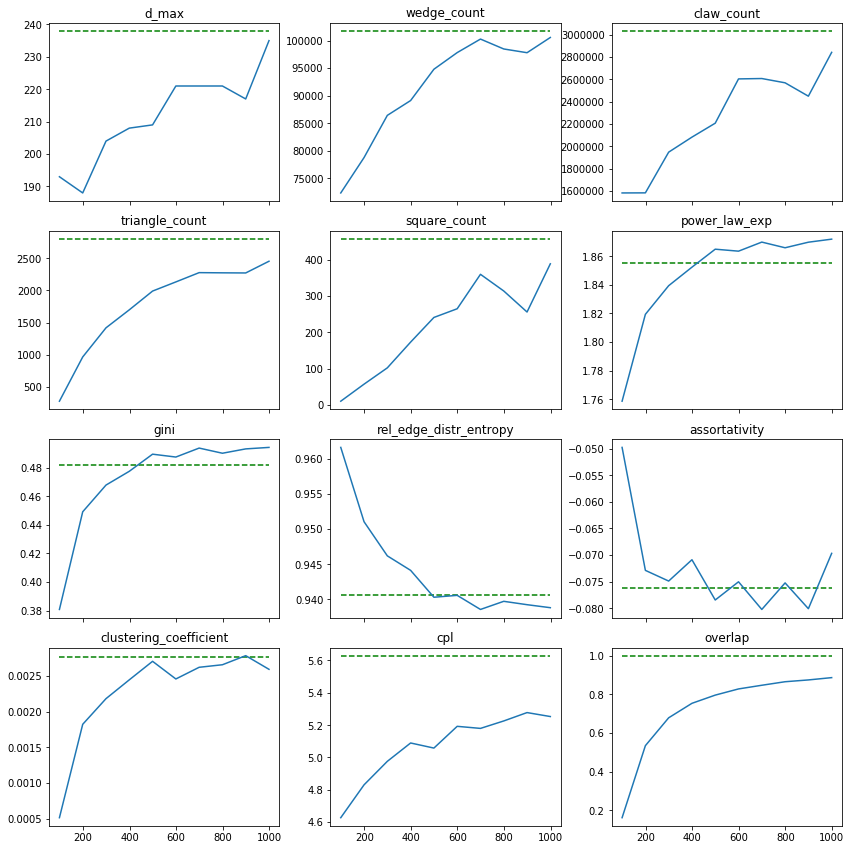

In [28]:
print_statistics(netmodel.loggers[0].dict_of_lists_of_statistic,
                 relevant_keys,
                 reference_dict_of_statistics=statistics_train)

In [49]:
np.ceil(np.sqrt(16))

4.0

In [50]:
for k in range(27):
    print(k, get_plot_grid_size(k))

0 (0, -1)
1 (1, 1)
2 (2, 1)
3 (2, 2)
4 (2, 2)
5 (3, 2)
6 (3, 2)
7 (3, 3)
8 (3, 3)
9 (3, 3)
10 (4, 3)
11 (4, 3)
12 (4, 3)
13 (4, 4)
14 (4, 4)
15 (4, 4)
16 (4, 4)
17 (5, 4)
18 (5, 4)
19 (5, 4)
20 (5, 4)
21 (5, 5)
22 (5, 5)
23 (5, 5)
24 (5, 5)
25 (5, 5)
26 (6, 5)


#### Build score matrix from trained model

In [12]:
transition_matrix = netmodel(torch.arange(start=0,end=_N, dtype=int))

scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                     symmetric=True,
                                                     mixing_coeff=mixing_coeff)
scores_matrix = sp.csr_matrix(scores_matrix)

#### Evaluate generalization via link prediction

In [13]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

print(roc_auc_score(test_labels, test_scores))
print(average_precision_score(test_labels, test_scores))

0.940075
0.9515720817205532


#### Build graph and evaluate graph statistics

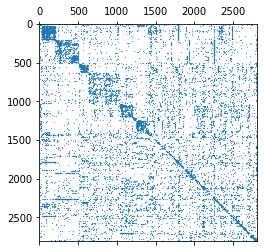

0.9286451422674333


In [14]:
sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())

plt.spy(sampled_graph, markersize=.2)
plt.show()

print(utils.edge_overlap(train_graph.toarray(), sampled_graph)/train_graph.sum())

In [15]:
statistics_sampled = utils.compute_graph_statistics(sampled_graph)
statistics_train = utils.compute_graph_statistics(train_graph.toarray())

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [16]:
df = pd.DataFrame([statistics_train, statistics_sampled], index=['CORA-ML', 'Our method'])

for index, row in df.iterrows():
    new_row = [f'{round(x, 4):,}' for x in list(row)]
    df.loc[index] = new_row

df[['d_max', 'assortativity', 'triangle_count', 
    'wedge_count', 'claw_count', 'power_law_exp', 
    'clustering_coefficient', 'rel_edge_distr_entropy', 
    'LCC', 'gini', 'cpl']]

,d_max,assortativity,triangle_count,wedge_count,claw_count,power_law_exp,clustering_coefficient,rel_edge_distr_entropy,LCC,gini,cpl
CORA-ML,238.0,-0.0763,"2,802.0","101,747.0","3,033,514.0",1.8551,0.0028,0.9407,"2,810.0",0.4819,5.63
Our method,226.0,-0.0782,"2,469.0","97,856.0","2,666,408.0",1.8553,0.0028,0.9413,"2,796.0",0.482,5.3219
